Download Data

In [6]:
from pandas_datareader import data as pdr
import yfinance as yf
# Get the stock quote
Apple_df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
# Show teh data
Apple_df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447411,6.462173,6.398304,6.429937,493729600
2010-01-05,6.458559,6.495012,6.424515,6.465187,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344076,6.386857,6.297982,6.379325,477131200
2010-01-08,6.386254,6.386857,6.298285,6.335642,447610800
...,...,...,...,...,...
2023-12-22,192.656174,194.457347,192.029240,194.228458,37122800
2023-12-26,192.108856,192.944757,191.889928,192.666124,28919300


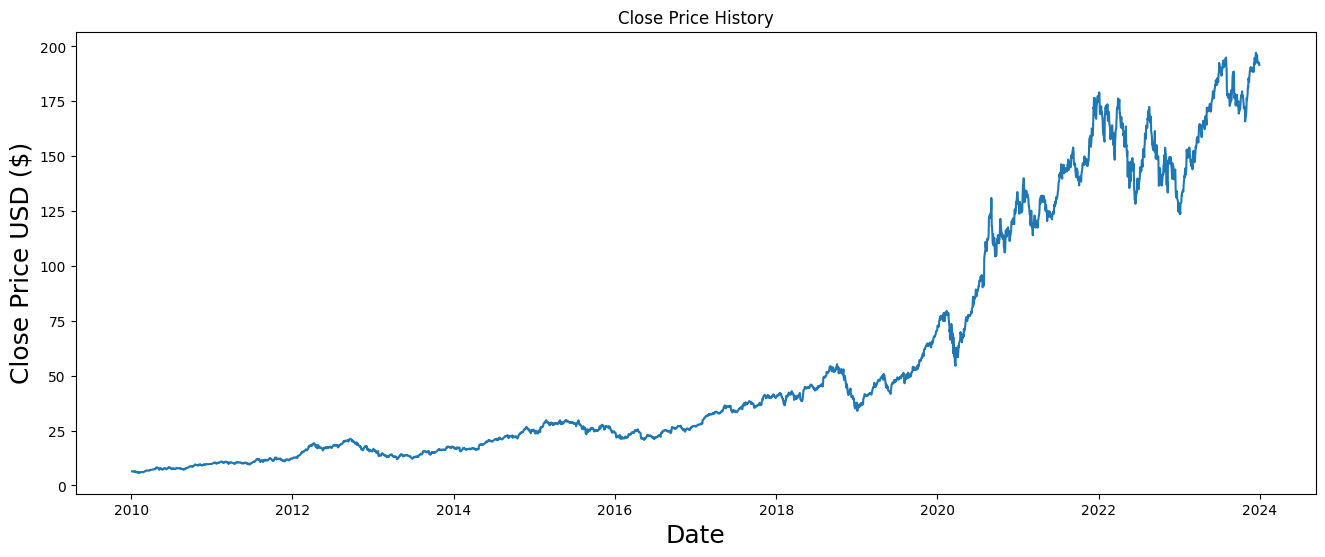

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(Apple_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Preprocessing data

In [8]:
import numpy as np
# Create a new dataframe with only the 'Close column 
data = Apple_df['Close']
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))  #80%
validation_data_len = int(np.ceil( len(dataset) * 0.1 ))  #10%

In [9]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #Normalize the data to between 0 and 1
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.00345728]
 [0.00351554]
 [0.00297869]
 ...
 [0.97420648]
 [0.97644269]
 [0.97098214]]


In [10]:
# Split the data into train valid test data sets
train_data = scaled_data[0:int(training_data_len),:]
valid_data = scaled_data[int(training_data_len):int(training_data_len)+int(validation_data_len),:]
test_data = scaled_data[int(training_data_len)+int(validation_data_len):,:]
x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = dataset[int(training_data_len)+int(validation_data_len)+120:, :] 
#Take data from positions 0-99 as features, data from position 100 as predicted values, and slide back one unit each time, such as 1-100 as features and 101 as predicted values.
#We call 120 as time step.
for i in range(120, len(train_data)):
    x_train.append(train_data[i-120:i, 0])  
    y_train.append(train_data[i, 0])

for i in range(120,len(valid_data)):
    x_valid.append(valid_data[i-120:i,0])
    y_valid.append(valid_data[i,0])

for i in range(120,len(test_data)):
    x_test.append(test_data[i-120:i,0])


            
# # Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_test = np.array(x_test)



# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

Build and train the model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False)) #
model.add(Dense(25,activation='relu'))
model.add(Dense(1))


# Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')
# Set a learning rate annealer
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
# Set early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,          # 10 epochs without improvement,then stop
    verbose=1,           
    restore_best_weights=True
)
# Set a checkpoint,saving the best model
checkpoint = ModelCheckpoint(
    filepath='stock_predict_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_valid,y_valid), batch_size=16, epochs=50,callbacks=[lr_reducer,early_stopping])


e:\codetool\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.0034 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 1.1997e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 1.3834e-04 - val_loss: 9.2392e-04 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 9.7803e-05 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 1.3101e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 1.0559e-04 - val_loss: 5.6427e-04 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 1.0078e-04 - val_loss: 5.4844e-04 - learning_rate: 0.0010
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - loss: 7.3692e-05 - val_loss: 5.0752e-04 - learning_rate: 0.0010
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss

In [16]:
model.save('stock_predict_model.keras')

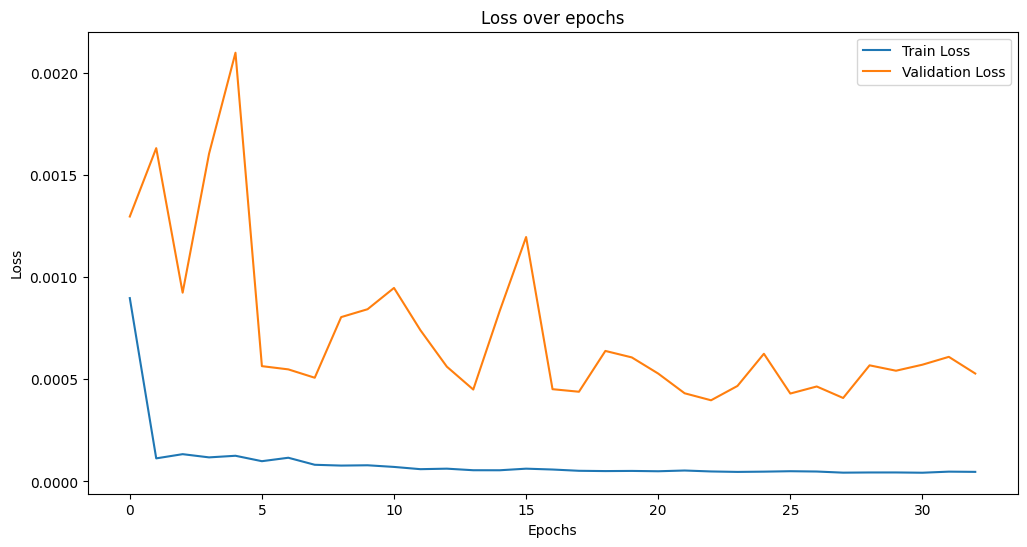

In [12]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
predictions = model.predict(x_test) 
#The predicted data is normalized, so put them back down. Why is there such a comparison? It is to make the error have practical significance, 
# and the normalized error does not show any representative meaning
predictions = scaler.inverse_transform(predictions) 
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
3.426112772160536


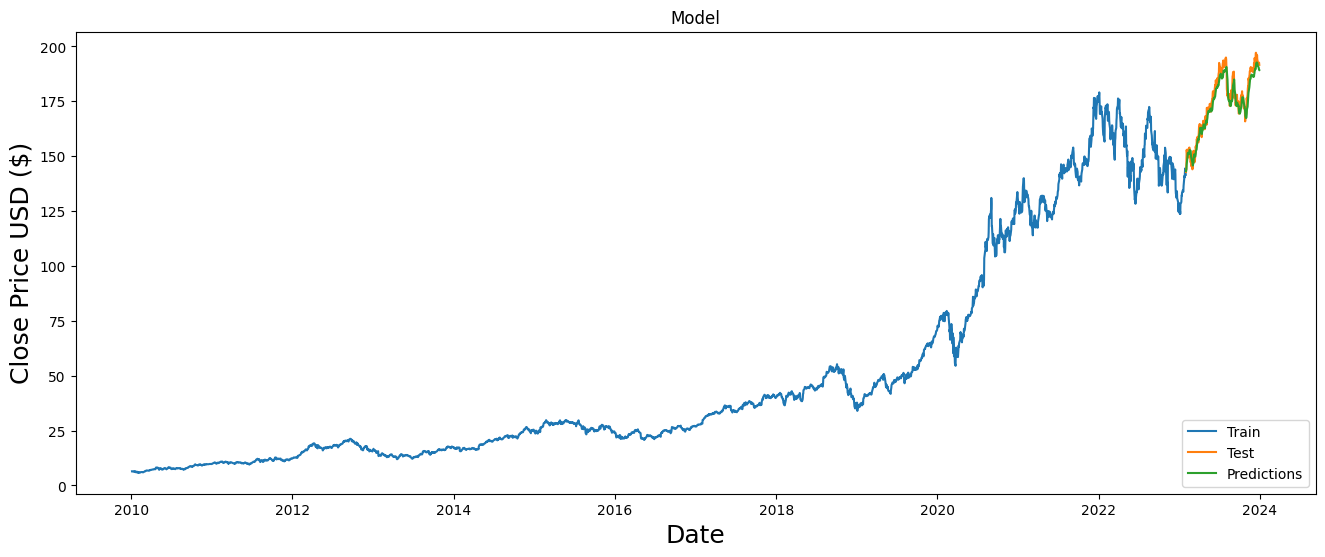

In [14]:
# Plot the data
train_original = Apple_df[0:int(training_data_len)+int(validation_data_len)+120] 
test_original = Apple_df[int(training_data_len)+int(validation_data_len)+120:]
test_original = test_original.copy()
test_original.loc[:,'Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_original['Close'])
plt.plot(test_original[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

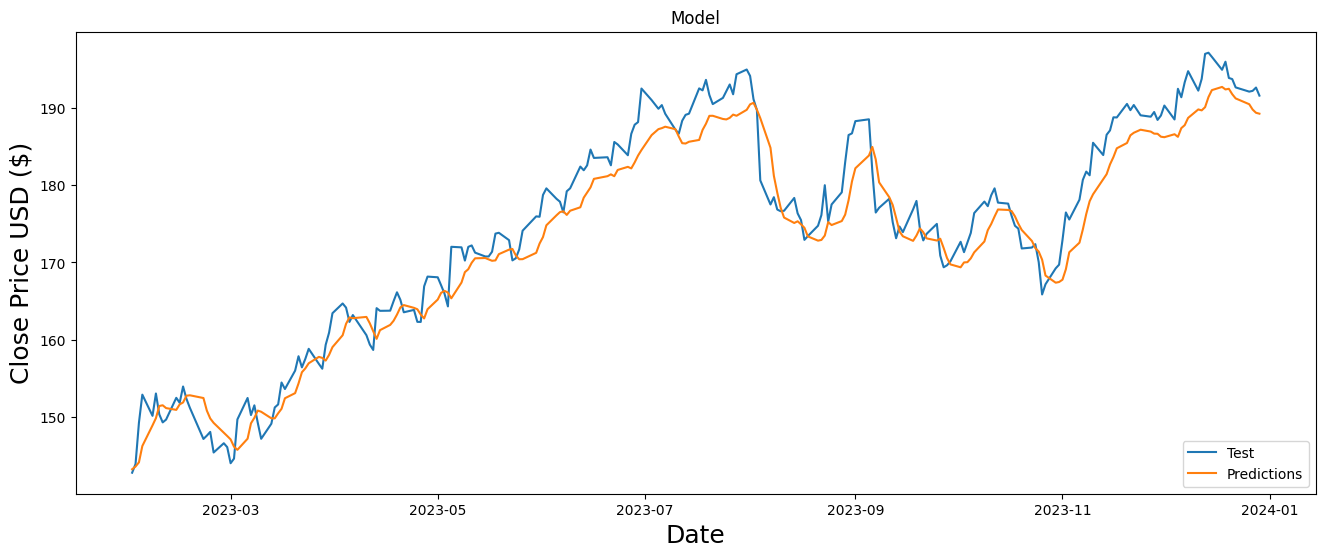

In [15]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(test_original[['Close', 'Predictions']])
plt.legend(['Test', 'Predictions'], loc='lower right')
plt.show()